In [1]:
import os

from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from easydict import EasyDict as edict
from imutils.paths import list_images
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.metrics import *
import torch.optim as optim
from tqdm.auto import tqdm
from PIL import Image
import torch.nn as nn
import pandas as pd
import numpy as np
import torch
import timm
import cv2

from utils.dataset_util import *

/opt/conda/envs/torch_1.x/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
SEP       = os.path.sep
ROOT_PATH = SEP.join(os.getcwd().split(SEP)[:-4])
DATA_PATH = f'{ROOT_PATH}/Datasets/music_notes'

args              = {}
args['n_samples'] = 5
args['seed']      = 99
args['lr']        = 1e-3
args['bs']        = 64
args['epochs']    = 30
args['device']    = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
args              = edict(args)

In [3]:
(images, labels), (lb2idx, idx2lb) = build_dataset(f'{DATA_PATH}/datasets')
lb2idx, idx2lb

({'Eight': 0, 'Quarter': 1, 'Whole': 2, 'Half': 3, 'Sixteenth': 4},
 {0: 'Eight', 1: 'Quarter', 2: 'Whole', 3: 'Half', 4: 'Sixteenth'})

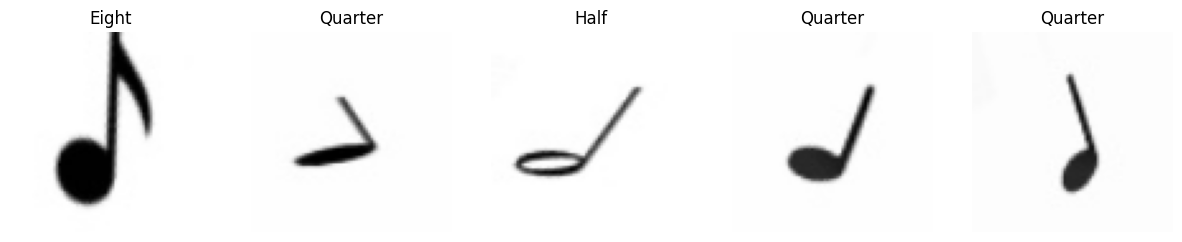

In [4]:
indexes     = np.random.randint(0, len(images), args.n_samples)
_, axes     = plt.subplots(1, 5, figsize = (args.n_samples * 3, args.n_samples))

for idx, ax in zip(indexes, axes):
    
    image = images[idx]
    label = labels[idx]
    
    ax.imshow(image, cmap = 'gray')
    ax.axis(False)
    ax.set_title(idx2lb[label])

In [5]:
train_x, valid_x, train_y, valid_y = train_test_split(images, labels, test_size = 0.2, shuffle = True,
                                                      stratify = labels, random_state = args.seed)
train_x, test_x , train_y, test_y  = train_test_split(train_x, train_y, test_size = 0.16, shuffle = True,
                                                      stratify = train_y, random_state = args.seed)

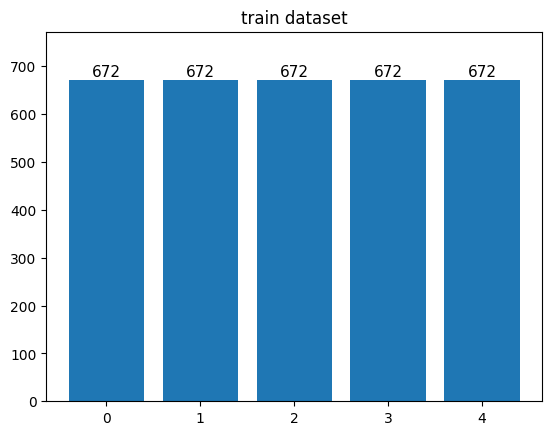

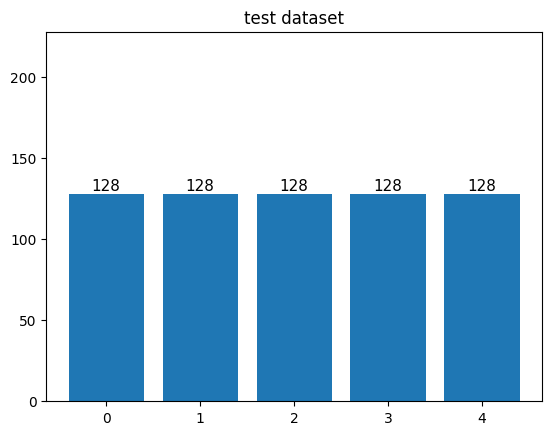

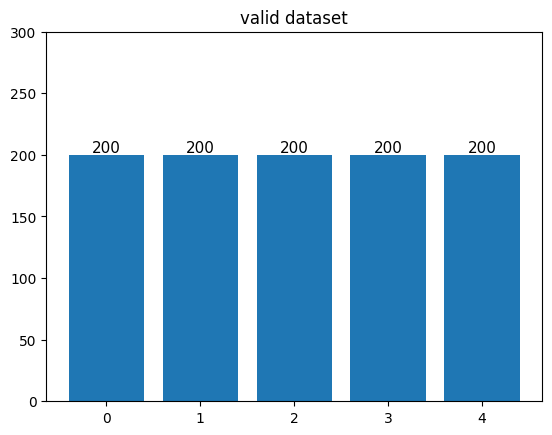

In [6]:
display_distribution(train_y)
display_distribution(test_y , dtype =  'test')
display_distribution(valid_y, dtype = 'valid')

In [7]:
class NoteDataset(Dataset):
    
    def __init__(self, images, labels, dtype = 'train'):
        
        self.images = images
        self.labels = labels
        self.dtype  = dtype
        
        self.transforms = {}
        self.transforms['train'] = transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.RandomRotation((-np.pi / 3, np.pi / 3)),
                                        transforms.Resize(64),
                                        transforms.ToTensor()
                                    ])
        
        self.transforms['test'] = transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.Resize(64),
                                        transforms.ToTensor()
                                        
                                    ])
        
    def __len__(self):
        return len(self.labels)
    
    
    def __getitem__(self, idx):
        
        image = self.images[idx]
        image = self.transforms[self.dtype](image)
        
        return image, self.labels[idx]

In [8]:
train_dataset = NoteDataset(train_x, train_y)
test_dataset  = NoteDataset( test_x,  test_y, dtype = 'test')
valid_dataset = NoteDataset(valid_x, valid_y, dtype = 'test')

train_loader  = DataLoader(train_dataset, batch_size = args.bs, shuffle =  True)
test_loader   = DataLoader(test_dataset , batch_size = args.bs, shuffle = False)
valid_loader  = DataLoader(valid_dataset, batch_size =       1, shuffle = False)

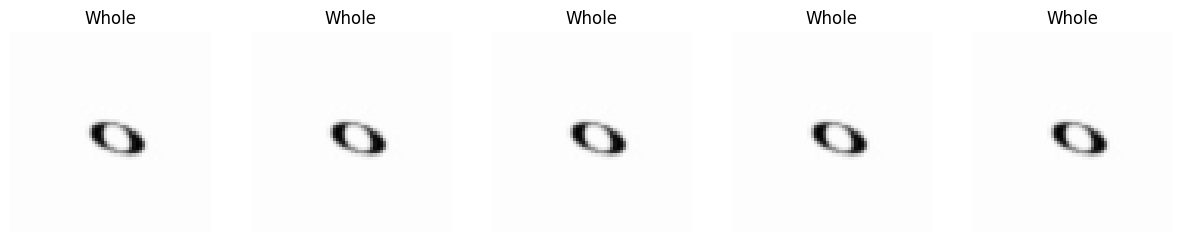

In [9]:
samples = next(iter(train_loader))
indexes = np.random.randint(0, len(samples), args.n_samples)
_, axes = plt.subplots(1, args.n_samples, figsize = (3 * args.n_samples, args.n_samples))

for idx, ax in zip(indexes, axes):
    
    image = samples[0][idx]
    label = samples[1][idx]
    ax.imshow(image.numpy().transpose(1, 2, 0), cmap = 'gray')
    ax.axis(False)
    ax.set_title(idx2lb[label.item()])

In [10]:
class NoteNet(nn.Module):
    
    def __init__(self, n_classes):
        
        super(NoteNet, self).__init__()
        self.conv1 = nn.Conv2d(3,  8, kernel_size = 3, stride = 1, padding = 1)
        self.bn1   = nn.BatchNorm2d(8)
        
        self.conv2 = nn.Conv2d(8, 16, kernel_size = 3, stride = 1, padding = 1)
        self.bn2   = nn.BatchNorm2d(16)
        
        self.conv3 = nn.Conv2d(16, 8, kernel_size = 3, stride = 1, padding = 1)
        self.bn3   = nn.BatchNorm2d(8)
        
        self.drop  = nn.Dropout2d()
        self.fc1   = nn.Linear(8*8*8, 32)
        self.fc2   = nn.Linear(32, 16)
        self.fc3   = nn.Linear(16, 8)
        self.fc4   = nn.Linear(8, n_classes)
        
    
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = self.bn1(x)
        
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = self.bn2(x)
        
        x = F.relu(F.max_pool2d(self.conv3(x), 2))
        x = self.bn3(x)
        
        x = x.view(-1, 8*8*8)
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        
        x = F.relu(self.fc2(x))
        x = self.drop(x)
        
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        
        return F.log_softmax(x, dim = 1)

In [11]:
model         = NoteNet(n_classes = len(idx2lb)).to(args.device)
optimizer     = optim.Adam(model.parameters(), lr = args.lr)
loss_function = torch.nn.CrossEntropyLoss()

logs          = {
                    'train_acc'  : [],
                    'train_loss' : [],
                    'valid_acc'  : [],
                    'valid_loss' : []
                }

/opt/conda/envs/torch_1.x/lib/python3.10/site-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [12]:
def train(model, loader, optim):
    
    correct = 0
    loss    = 0
    
    model.train()
    for batch in loader:
        
        image, label = batch
        image  = image.to(args.device)
        label  = label.to(args.device)
        optim.zero_grad()
        
        output = model(image)
        loss_  = loss_function(output, label)
        
        loss_.backward()
        optim.step()
        
        pred   = output.max(1, keepdim = True)[1]
        correct += pred.eq(label.view_as(pred)).sum().item()
        loss    += loss_.item()
        
        
    loss /= len(loader.dataset)
    acc   = 100 * correct / len(loader.dataset)
    
    return loss, acc


def evaluate(model, loader):
    
    correct = 0
    loss    = 0
    
    model.eval()
    with torch.no_grad():
        for batch in loader:
            image, label = batch
            image        = image.to(args.device)
            label        = label.to(args.device)

            output       = model(image)
            loss_        = loss_function(output, label)
            pred         = output.max(1, keepdim = True)[1]
            
            correct     += pred.eq(label.view_as(pred)).sum().item()
            loss        += loss_.item()
    
    loss /= len(loader.dataset)
    acc   = 100 * correct / len(loader.dataset)
    
    return loss, acc

In [13]:
for epoch in range(1, args.epochs + 1):
    
    train_loss, train_acc = train(model, train_loader, optimizer)
    test_loss , test_acc  = evaluate(model, test_loader)
    
    logs['train_acc'].append(train_acc)
    logs['train_loss'].append(train_loss)
    
    logs['valid_acc'].append(test_acc)
    logs['valid_loss'].append(test_loss)
    
    print(f'[{epoch}/{args.epochs}]')
    print(f'[TRAIN] loss : {train_loss:.3f} / accuracy : {train_acc:.3f}%')
    print(f'[TEST]  loss : {test_loss:.3f}  / accuracy : {test_acc:.3f}%\n')

/opt/conda/envs/torch_1.x/lib/python3.10/site-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


[1/30]
[TRAIN] loss : 0.024 / accuracy : 31.220%
[TEST]  loss : 0.022  / accuracy : 46.406%

[2/30]
[TRAIN] loss : 0.019 / accuracy : 51.488%
[TEST]  loss : 0.015  / accuracy : 67.031%

[3/30]
[TRAIN] loss : 0.016 / accuracy : 60.149%
[TEST]  loss : 0.013  / accuracy : 63.594%

[4/30]
[TRAIN] loss : 0.013 / accuracy : 64.256%
[TEST]  loss : 0.011  / accuracy : 75.000%

[5/30]
[TRAIN] loss : 0.011 / accuracy : 66.399%
[TEST]  loss : 0.008  / accuracy : 76.562%

[6/30]
[TRAIN] loss : 0.009 / accuracy : 71.815%
[TEST]  loss : 0.007  / accuracy : 91.250%

[7/30]
[TRAIN] loss : 0.008 / accuracy : 79.286%
[TEST]  loss : 0.033  / accuracy : 46.875%

[8/30]
[TRAIN] loss : 0.007 / accuracy : 85.446%
[TEST]  loss : 0.021  / accuracy : 53.281%

[9/30]
[TRAIN] loss : 0.006 / accuracy : 88.333%
[TEST]  loss : 0.004  / accuracy : 96.250%

[10/30]
[TRAIN] loss : 0.005 / accuracy : 91.905%
[TEST]  loss : 0.006  / accuracy : 79.219%

[11/30]
[TRAIN] loss : 0.005 / accuracy : 93.095%
[TEST]  loss : 0.02

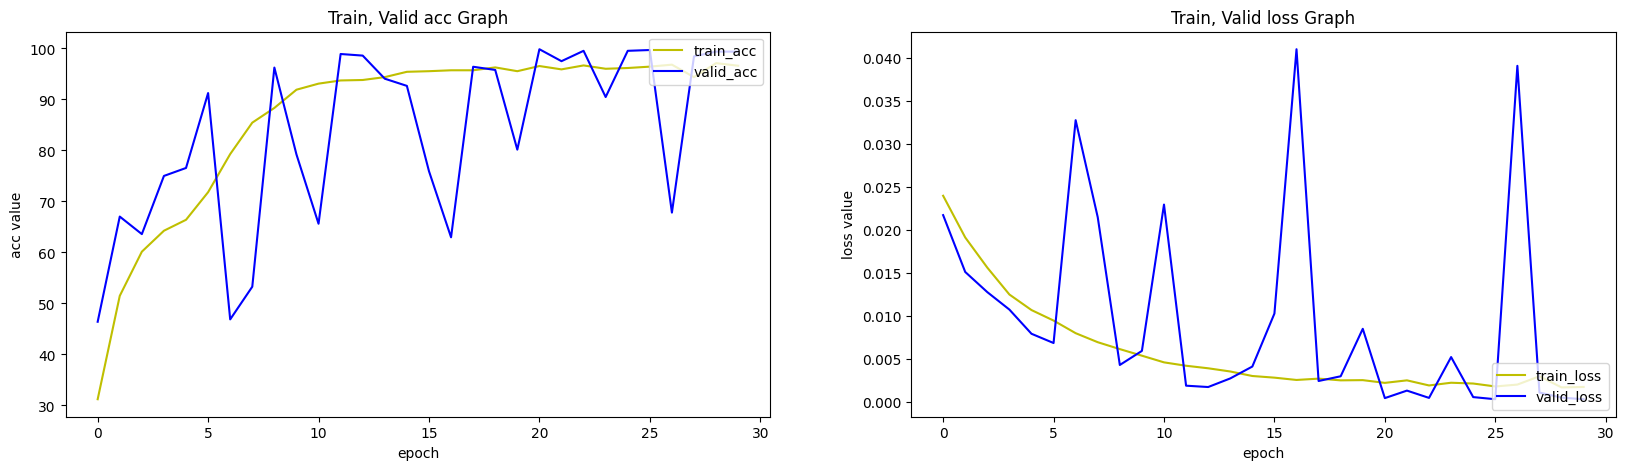

In [14]:
display_history(logs, args.epochs)

In [15]:
gt, predicted = [], []
to_numpy      = lambda x: x.detach().cpu().numpy() if x.is_cuda else x.cpu().numpy()

model.eval()
with torch.no_grad():
    
    for batch in valid_loader:
        
        image, label = batch
        image = image.to(args.device)
        label = label.to(args.device)
        
        output = model(image)
        pred   = output.max(1, keepdim = True)[1]
        
        gt.extend(to_numpy(label))
        predicted.extend(to_numpy(pred[0]))

In [16]:
print(f'[VALIDATION] accuracy score : {accuracy_score(gt, predicted)}')
print(classification_report(gt, predicted))

[VALIDATION] accuracy score : 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       200
           1       1.00      1.00      1.00       200
           2       1.00      1.00      1.00       200
           3       1.00      1.00      1.00       200
           4       1.00      1.00      1.00       200

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000

